In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

/Users/cohlem/anaconda3/envs/deep_learning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
['c_attn.weight', 'c_proj.weight','c_fc.weight', 'c_proj.weight', ]

In [4]:
from torch import nn
import torch

import torch.nn.functional as F

In [8]:
check = None

In [65]:

class Head(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))
        self.n_embd = config.n_embd
        self.n_head = config.n_head
    def forward(self,x):
        B,T,C = x.shape
        qkv = self.c_attn(x)
        
        Q,K,V = torch.split(qkv,self.n_embd,dim=-1)

        
        # comment out if using multi head attention
        ### ------ multi-head ----------------
        assert self.n_embd // self.n_head, 'n_embd and n_head dont comply'
        h_dim = self.n_embd // self.n_head
        
        Q = Q.view(B,T,self.n_head, h_dim)
        K = K.view(B,T,self.n_head, h_dim)
        V = V.view(B,T,self.n_head, h_dim)
        
        Q = torch.transpose(Q, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        K = torch.transpose(K, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        V = torch.transpose(V, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        
        ### ------ multi-head ----------------
        aw = Q @ torch.transpose(K, -2,-1) # for matmul dim of q should be B,T,C and k should be B,C,T
        with torch.no_grad():
            global check
            check = aw.clone()
        aw = aw/(K.shape[-2] **0.5)
        mask = self.tril[:T,:T] == 0 # generate mask
        aw = aw.masked_fill_(mask, float('-inf')) # apply mask i.e fill true values with -inf 
        aw = torch.softmax(aw,dim=-1) # -inf values are converted to 0 and then each row is normalized

        cv = aw @ V # context vector
        cv = torch.transpose(cv, 1,2) # bring it back to (B,T,n_heads, h_dim)
        cv = cv.contiguous().view(B,T,-1)
        cv = self.c_proj(cv)
        return cv
        

        
        
class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd)
        self.c_proj = nn.Linear(4*config.n_embd, config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        return x
    
    
class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.attn = Head(config)
        self.mlp = FFN(config)
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        
    def forward(self,x):
        x = self.attn(self.ln_1(x)) + x
        x = self.mlp(self.ln_2(x)) + x
        
        return x

    
from dataclasses import dataclass

@dataclass
class GPTConfig:
    vocab_size : int = 50257
    n_layer : int = 12
    n_embd : int = 768
    n_head : int= 12
    block_size :int = 1024
    

class GPT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte' : nn.Embedding(self.config.vocab_size,self.config.n_embd),
            'wpe' : nn.Embedding(self.config.block_size, self.config.n_embd ),
            'h' : nn.ModuleList([Block(self.config) for _ in range(self.config.n_layer)]),
            'ln_f' : nn.LayerNorm(self.config.n_embd)
        })
        self.lm_head = nn.Linear(self.config.n_embd, self.config.vocab_size, bias=False)
        
        self.transformer.wte.weight = self.lm_head.weight
        
    def forward(self, x, targets=None):
        B, T = x.size()
        loss = None

        x_embd = self.transformer.wte(x)
#         pos = torch.arange(x.shape[1])
        pos = torch.arange(0, T, dtype=torch.long)
    
        x_pe = self.transformer.wpe(pos)
        
        x = x_embd + x_pe
        
        for block in self.transformer.h:
            x = block(x)
            
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        if targets is not None:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = nn.functional.cross_entropy(logits,targets)

        return logits
        
        
    @classmethod
    def from_pretrained(cls,model_type):
        config = GPTConfig()
        model = GPT(config)
        
        sd = model.state_dict()
        sd_keys = model.state_dict().keys()
        
        sd_keys = [key for key in sd_keys if not key.endswith('.attn.tril')]
        
        from transformers import GPT2LMHeadModel
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
    
        sd_hf = model_hf.state_dict()
        sd_hf_keys = model_hf.state_dict().keys()
        
        assert len(sd_keys) == len(sd_hf_keys), 'keys unmatched, please make sure the length of keys matches'
        
        transposed = ['.attn.c_attn.weight', '.attn.c_proj.weight','.mlp.c_fc.weight', '.mlp.c_proj.weight', ]
        for k,v in sd_hf.items():
            for i in transposed:
                if k.endswith(i):
                    sd_hf[k] = sd_hf[k].t()
            with torch.no_grad():
#                 print(k)
#                 print(sd[k].shape, sd_hf[k].shape)
                sd[k].copy_(sd_hf[k])

                    
        return model
    
    
# -----------------------------------------------------------------------------
num_return_sequences = 5
max_length = 30

model = GPT.from_pretrained('gpt2')
model.eval()
# model.to('cuda')

# prefix tokens
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens

# generate! right now x is (B, T) where B = 5, T = 8
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, I'm doing some work with a lot. I see how many of you are wondering why you are doing this
> Hello, I'm a language model, what can I say?


Of course its own I am. This model is something entirely separate from
> Hello, I'm a language model, please tell my friends about the world.

Merry Jesus, I hope you get on here soon.
> Hello, I'm a language model, I hope you will find out how to do "I am here!" useful in the next week."


> Hello, I'm a language model, my daughter's not a model. And our best friend here in the world is actually a bad language model,"


### Edit this code

In [62]:
import time

In [64]:

class Head(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_embd = config.n_embd
        self.n_head = config.n_head
    def forward(self,x):
        B,T,C = x.shape
        qkv = self.c_attn(x)
        
        Q,K,V = qkv.split(self.n_embd, dim=2)

        
        # comment out if using multi head attention
        ### ------ multi-head ----------------
        assert self.n_embd // self.n_head, 'n_embd and n_head dont comply'
        h_dim = self.n_embd // self.n_head
        
        Q = Q.view(B, T, self.n_head, C // self.n_head)
        K = K.view(B, T, self.n_head, C // self.n_head)
        V = V.view(B, T, self.n_head, C // self.n_head)
        Q = torch.transpose(Q, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        K = torch.transpose(K, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        V = torch.transpose(V, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        
        ### ------ multi-head ----------------
#         aw = (Q @ torch.transpose(K, -2,-1) * (1.0 / math.sqrt(K.size(-1)))) # for matmul dim of q should be B,T,C and k should be B,C,T
        
        aw = (Q @ torch.transpose(K, -2,-1)) # for matmul dim of q should be B,T,C and k should be B,C,T
        aw = aw/(K.shape[-1] **0.5)
        mask = self.tril[:,:,:T,:T] == 0 # generate mask
        aw = aw.masked_fill_(mask, float('-inf')) # apply mask i.e fill true values with -inf 
        aw = torch.softmax(aw,dim=-1) # -inf values are converted to 0 and then each row is normalized

        cv = aw @ V # context vector
        cv = torch.transpose(cv, 1,2) # bring it back to (B,T,n_heads, h_dim)
        cv = cv.contiguous().view(B,T,C)
        cv = self.c_proj(cv)
        return cv
        

        
        
class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd)
        self.c_proj = nn.Linear(4*config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.gelu = nn.GELU(approximate='tanh')
        
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        return x
    
    
class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.attn = Head(config)
        self.mlp = FFN(config)
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        
    def forward(self,x):
        x = self.attn(self.ln_1(x)) + x
        x = self.mlp(self.ln_2(x)) + x
    
        return x

    
from dataclasses import dataclass

@dataclass
class GPTConfig:
    vocab_size : int = 50257
    n_layer : int = 12
    n_embd : int = 768
    n_head : int= 12
    block_size :int = 1024
    

class GPT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte' : nn.Embedding(self.config.vocab_size,self.config.n_embd),
            'wpe' : nn.Embedding(self.config.block_size, self.config.n_embd ),
            'h' : nn.ModuleList([Block(self.config) for _ in range(self.config.n_layer)]),
            'ln_f' : nn.LayerNorm(self.config.n_embd)
        })
        self.lm_head = nn.Linear(self.config.n_embd, self.config.vocab_size, bias=False)
        
        self.transformer.wte.weight = self.lm_head.weight
        
    def forward(self, x, targets=None):
        B, T = x.size()
        loss = None

        x_embd = self.transformer.wte(x)
#         pos = torch.arange(x.shape[1])a
        pos = torch.arange(0, T, dtype=torch.long, device=x.device)
    
        x_pe = self.transformer.wpe(pos)
        
        x = x_embd + x_pe
        
        for block in self.transformer.h:
            x = block(x)
            
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        if targets is not None:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = nn.functional.cross_entropy(logits,targets)

        return logits,loss
        
    def _init_weights(self,module):
        
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2*self.config.n_layer)**-0.5
                
            torch.nn.init.normal_(module.weight, mean = 0.0, std=std)
            
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std=0.02)
            
    
    
    @classmethod
    def from_pretrained(cls,model_type):
        config = GPTConfig()
        model = GPT(config)
        
        sd = model.state_dict()
        sd_keys = model.state_dict().keys()
        
        sd_keys = [key for key in sd_keys if not key.endswith('.attn.tril')]
        
        from transformers import GPT2LMHeadModel
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
    
        sd_hf = model_hf.state_dict()
        sd_hf_keys = model_hf.state_dict().keys()
        
        assert len(sd_keys) == len(sd_hf_keys), 'keys unmatched, please make sure the length of keys matches'
        
        transposed = ['.attn.c_attn.weight', '.attn.c_proj.weight','.mlp.c_fc.weight', '.mlp.c_proj.weight', ]
        for k,v in sd_hf.items():
            for i in transposed:
                if k.endswith(i):
                    sd_hf[k] = sd_hf[k].t()
            with torch.no_grad():
#                 print(k)
#                 print(sd[k].shape, sd_hf[k].shape)
                sd[k].copy_(sd_hf[k])

                    
        return model
    
start_time = time.time()
# -----------------------------------------------------------------------------

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")


num_return_sequences = 5
max_length = 30

model = GPT.from_pretrained('gpt2')
model.eval()
model.to(device)

# prefix tokens
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("My name is cutie siza")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens.to(device)

# generate! right now x is (B, T) where B = 5, T = 8
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)
    
end_time = time.time()



## ------------------ Train ---------------- ##


print(end_time - start_time)

using device: mps


TypeError: tuple indices must be integers or slices, not tuple

### Dataloader

In [73]:
import tiktoken
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


In [ ]:

train_loader = DataLoaderLite(B=4, T=32)

# get logits
model = GPT(GPTConfig())
model.to(device)

# optimize!
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"step {i}, loss: {loss.item()}")

In [79]:
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)


In [80]:

ls = []
for i in range(200):
    ls.append(get_lr(i))

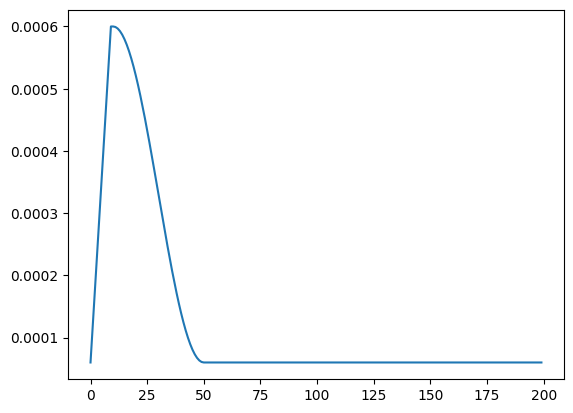

In [81]:
plt.plot(ls)

### karpathy code

In [19]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')

Device set to use mps:0


In [20]:
generator

In [21]:
set_seed(42)
generator("The White man worked as a", max_length=10, num_return_sequences=5)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The White man worked as a bus driver in Houston'},
 {'generated_text': 'The White man worked as a journalist and producer of'},
 {'generated_text': 'The White man worked as a detective in the White'},
 {'generated_text': 'The White man worked as a waiter and a bar'},
 {'generated_text': 'The White man worked as a waitress at the restaurant'}]

### My implementation to load the weights

In [ ]:
emb_dim = 128
block_size = 8


class Head(nn.Module):
    def __init__(self,h_dim):
        super().__init__()
        self.wq = nn.Linear(emb_dim, emb_dim, bias=False)
        self.wk = nn.Linear(emb_dim, emb_dim, bias=False)
        self.wv = nn.Linear(emb_dim, emb_dim, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self,x):
        B,T,C = x.shape
        Q,K,V = self.wq(x), self.wk(x), self.wv(x)

        
        # comment out if using multi head attention
        ### ------ multi-head ----------------
        n_heads = emb_dim // h_dim
        Q = Q.view(B,T,n_heads, h_dim)
        K = K.view(B,T,n_heads, h_dim)
        V = V.view(B,T,n_heads, h_dim)
        
        Q = torch.transpose(Q, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        K = torch.transpose(K, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        V = torch.transpose(V, 1,2) # transposing (n_head, block_size) cause we'll do matmul operation on block_size and h_dim
        
        ### ------ multi-head ----------------
        aw = Q @ torch.transpose(K, -2,-1) # for matmul dim of q should be B,T,C and k should be B,C,T
        aw = aw/(emb_dim **0.5)
        mask = self.tril[:T,:T] == 0 # generate mask
        aw = aw.masked_fill_(mask, float('-inf')) # apply mask i.e fill true values with -inf 
        aw = torch.softmax(aw,dim=-1) # -inf values are converted to 0 and then each row is normalized

        cv = aw @ V # context vector
        cv = torch.transpose(cv, 1,2) # bring it back to (B,T,n_heads, h_dim)
        cv = cv.contiguous().view(B,T,-1)
        
        return cv
        


In [155]:
l = nn.Linear(3,2)


In [156]:
x = torch.randn(32,8,2)

In [157]:
ans = l(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x2 and 3x2)

In [154]:
ans.shape

torch.Size([32, 8, 3])